# A basic history matching example using a deterministic function

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random

We present a basic example of history matching using a deterministic function with noise as the model that history matching is performed on.

This example is taken from:
Andrianakis, I.; Vernon, I. R.; McCreesh, N.; McKinley, T. J.; Oakley, J. E.; Nsubuga, R. N.; Goldstein, M. & White, R. G. Bayesian history matching of complex infectious disease models using emulation: a tutorial and a case study on HIV in Uganda PLoS computational biology, Public Library of Science, 2015, 11

We want to find the range of values in X that, given to the simulator, may produce the result y = -0.7

In [2]:
y = -0.7  # observation we want to find with the model

The simulator uses a sin function with added noise.

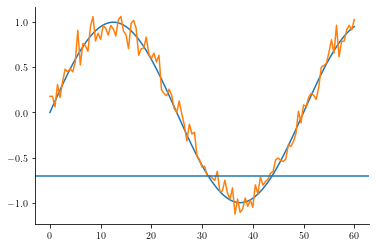

In [3]:
def f(x):
    """ the simulator """
    return math.sin(0.04 * math.pi * x)  + random.gauss(0, 0.1)


# example plot of simulator output
X = np.linspace(0, 60, 121)
plt.plot(X, [math.sin(0.04 * math.pi * x) for x in X])  # without noise
plt.plot(X, [f(x) for x in X])  # with simulator results
plt.axhline(y=y, xmin=0, xmax=1)  # observation

Calculate the variance in the model output by testing different inputs for multiple (k) runs and calculating the variance of those runs (for each input). Then calculate the mean across those variances.

In [4]:
k = 30  # total ensembles runs for each input
def get_v_ens(X):
    vars_range = []
    for x in X:
        vars_range.append(np.var([f(x) for _ in range(k)], ddof=1))
    return np.mean(vars_range)

v_ens = get_v_ens(range(0, 60, 6))

print("Ensemble variance:", v_ens)

Ensemble variance: 0.010042634470141474


The implausibility score takes the difference between the simulator result and the observation, and divides this by all uncertainties in the model. At the moment, there is only variability in the ensemble results (v_ens).
It could also take into account uncertainty in the observation and model discrepency.

In [5]:
def implaus(x):
    """ Calculate the implausibility of the paramter value x"""
    num = abs(y - f(x))  # no emulator, only simulator
    denom = np.sqrt(v_ens)
    return num / denom

Run the first wave of history matching and plot the implausibility of each sample in the sample space (X).
The plot shows orange for implausible values (where implausibility is above 3) and blue for plausible values.

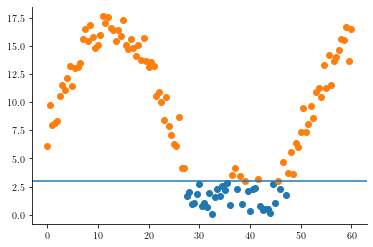

In [6]:
def wave(implaus_space):
    plaus_space = []
    # plot the results
    for x in implaus_space:
        score = implaus(x)
        if score < 3:
            plt.scatter(x, score, color=u'#1f77b4')
            plaus_space.append(x)
        else:
            plt.scatter(x, score, color=u'#ff7f0e')
    plt.axhline(y=3, xmin=0, xmax=1)
    return np.array(plaus_space)


# The sampling space would normally be chosen using an LHS-design,
# but this is a basic deterministic example so linspace will suffice.
X = np.linspace(0, 60, 121)
plaus_X = wave(X)

These results show that values in the range [28, 45.5] are considered plausible.
These ranges will differ each time the wave is run due to the Gaussian noise added to the simulator.

# Approximate Bayesian Computation on a deterministic example

History matching helped us narrow down the space of plausible inputs. Next, we can perform Approximate Bayesian Computation (ABC) to obtain probabilities for each point in the plausible space.

To achieve this, we use the package pyabc.

In [7]:
import pyabc

import numpy as np
import math
import scipy.stats as st
import tempfile
import os
import pandas as pd
import random
import matplotlib.pyplot as plt


First, define the model. This model is the same as above but now the function model is returning a dict. A dict is overkill, but it demonstrates how we can easily expand ABC if we have multiple outputs within the dict.

In [8]:
def model(parameter):
    return {"data": math.sin(0.04 * math.pi * parameter["x"])+ random.gauss(0, 0.1)}

Define the distance function; i.e. how we measure the error of the simulation against the observation. This is usually a simple meausure of difference.

In [9]:
def distance(x, y):
    return abs(x["data"] - y["data"])

Define our prior distribution for the parameter space. Through history matching, we found values between [28, 45.5] were deemed plausible inputs. We therefore set our prior as a uniform distribution in the range [28, 28+17.5].

In [10]:
prior = pyabc.Distribution(x=pyabc.RV("uniform", 28, 17.5))

Initiate the ABC object.

In [11]:
abc = pyabc.ABCSMC(model, prior, distance)

INFO:Sampler:Parallelizing the sampling on 4 cores.


Add a database of our knowledge of the observation to the ABC.

In [12]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
observation = -0.7
abc.new(db_path, {"data": observation})

INFO:History:Start <ABCSMC(id=2, start_time=2020-11-23 10:40:52.996754, end_time=None)>


Run ABC

In [13]:
history = abc.run(minimum_epsilon=.1, max_nr_populations=10)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.15908465357597623
INFO:ABC:t: 0, eps: 0.15908465357597623.
INFO:ABC:Acceptance rate: 100 / 253 = 3.9526e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.07723733689673427.
INFO:ABC:Acceptance rate: 100 / 376 = 2.6596e-01, ESS=9.7573e+01.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=2, start_time=2020-11-23 10:40:52.996754, end_time=2020-11-23 10:40:58.677084)>


Plot the results

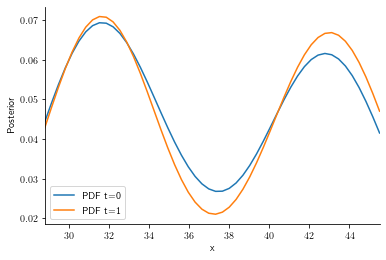

In [14]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=28.8, xmax=45.5,
        x="x", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(observation, color="k", linestyle="dashed")
ax.legend()

The plot shows that ABC has enabled us to correctly identify paramters of higher probability.

## Find the mode

Next, we get the mode of the distribution.

In [15]:
# this time get visualization to return the X and Y coordinates for the plot (using pyabc.visualization.kde.kde_1d)
# instead of returning the plot itself, as before (using pyabc.visualization.plot_kde_1d)

for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    X, Y = pyabc.visualization.kde.kde_1d(df, w, x='x')
    mode = X[np.where(Y == max(Y))]
    print('t:%d, mode:%f' % (t, mode))

t:0, mode:31.798623
t:1, mode:31.522351


## An example of ABC in a discrete parameter space

Next, we consider if our parameter space can only take discrete values.

Define the prior

In [15]:
# domain of possible discrete values
discrete_domain = range(28, 47)

# priors
# let each value in the domain have an equal prior probability
width = len(discrete_domain)
prior = pyabc.Distribution(
          x=pyabc.RV('rv_discrete', values=(discrete_domain, [1/width] * width)))

# transition kernels
transition = pyabc.AggregatedTransition(mapping={
    'x': pyabc.DiscreteJumpTransition(domain=discrete_domain, p_stay=0.7)})

Set up the observations and run the model

In [16]:
abc = pyabc.ABCSMC(model, prior, distance, transitions=transition, population_size=1000)
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
observation = -0.7
abc.new(db_path, {"data": observation})
history = abc.run(max_nr_populations=5)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=2, start_time=2020-11-04 09:39:14.043014, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.19533801832606862
INFO:ABC:t: 0, eps: 0.19533801832606862.
INFO:ABC:Acceptance rate: 1000 / 1899 = 5.2659e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.10660846421987495.
INFO:ABC:Acceptance rate: 1000 / 2785 = 3.5907e-01, ESS=9.3187e+02.
INFO:ABC:t: 2, eps: 0.05617222367931417.
INFO:ABC:Acceptance rate: 1000 / 4142 = 2.4143e-01, ESS=8.2711e+02.
INFO:ABC:t: 3, eps: 0.029862364775652035.
INFO:ABC:Acceptance rate: 1000 / 7765 = 1.2878e-01, ESS=8.0787e+02.
INFO:ABC:t: 4, eps: 0.01482775630813066.
INFO:ABC:Acceptance rate: 1000 / 14358 = 6.9648e-02, ESS=7.6011e+02.
INFO:History:Done <ABCSMC(id=2, start_time=2020-11-04 09:39:14.043014, end_time=2020-11-04 09:39:55.367976)>


Plot the results

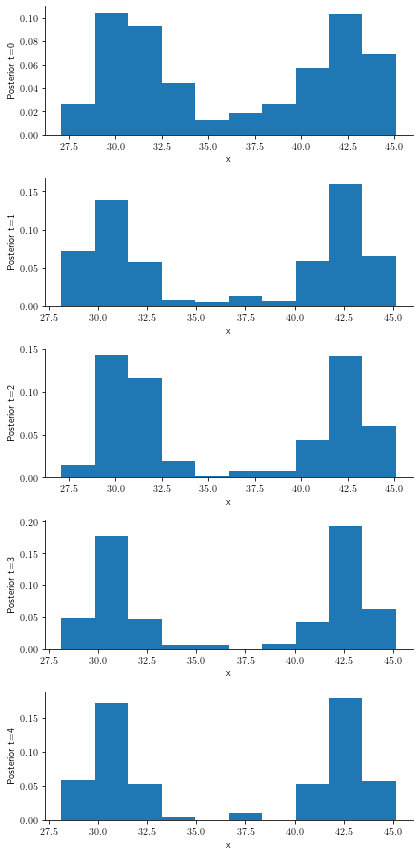

In [17]:
fig, axes = plt.subplots(history.max_t+1, 1, figsize=(6, 12))
for t in range(history.max_t+1):
    pyabc.visualization.plot_histogram_1d(
        history, 'x', t=t, align='left', ax=axes[t])
    axes[t].set_ylabel(f"Posterior t={t}")
fig.tight_layout()
plt.show()


# An example of history matching using stationsim

In this case, I'm using an "identical twin", in which one run of a simulation is used as the real world observation. This was run with default settings, with a population of 75 and random seed 1376479047.

The goal is to explore the parameter space of speed_mean to find a range of values with which the simulation takes the expected amount of time (i.e. all people have left the station area in the measured time).

The identical twin used the default speed_mean:1.

In [9]:
from sys import path
path.append('..')  # change as required
from stationsim.stationsim_model import Model

# "real world" observation
y = 1802
y_pop_total = 75
y_seed = 1376479047

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
def f(x):
    model = Model(pop_total=y_pop_total, speed_mean=x, do_print=False)
    for _ in range(model.step_limit):
        model.step()
    return model.step_id  # finish time

In [11]:
# test five different inputs
v_ens = get_v_ens(linspace(0.4, 6, 5))

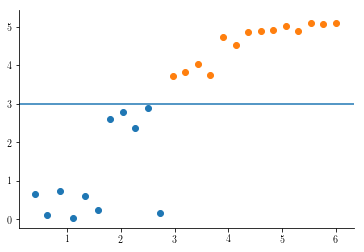

In [12]:
# Test speed_mean in the range [0.4, 6].
# Again, the sampling space would normally be chosen using an LHS-design.
# I'm keeping it very simple for now.
X = np.linspace(0.4, 6, 25)
plaus_X = wave(X)

Values around 0.4 to 2.7 are considered plausible. Higher values are implausible.
The results seem about right given the correct result should be 1.
As the simulator is stochastic, these ranges will be different each time

Now do the second wave, testing within the new plausible region.
The code I've done for this is overly simple because
1. it assumes the plausible region is convex
2. there is no clever sampling (I'm using linspace still)

First, get the variance in this region.

In [13]:
# get variance in new plausible region
v_ens = get_v_ens(np.linspace(min(plaus_X), max(plaus_X), 5))

Second, test the plausibility of this new region with the new ensemble variance.

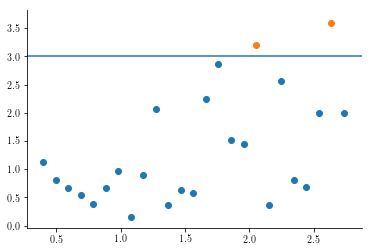

In [14]:
X = np.linspace(min(plaus_X), max(plaus_X), 25)
plaus_X = wave(X)

Nothing has really changed. History matching doesn't enable us to narrow down the plausible space any further.

# 